In [1]:
import pandas as pd
import spacy
from spacy.language import Language

nlp = spacy.load("en_core_web_sm")
nlp.add_pipe("merge_noun_chunks")
nlp.add_pipe("merge_entities")

# @Language.component("remove_stopwords")
# def remove_stopwords(doc):
#     # This will remove stopwords and punctuation.
#     # Use token.text to return strings, which we'll need for Gensim.
#     doc = [token.text for token in doc if token.is_stop != True and token.is_punct != True]
#     return doc

#nlp.add_pipe("remove_stopwords")

<function spacy.pipeline.functions.merge_entities(doc: spacy.tokens.doc.Doc)>

In [2]:
df = pd.read_csv('corpus_sample/sample.csv')
#print(df)

In [9]:
body_text = df.loc[:, 'body_text']

emails = []

for text in body_text:
    email = nlp(text)
    emails.append([token.text.lower() for token in email if not token.is_stop and token.text.isalpha()])

In [10]:
import gensim
import gensim.corpora as corpora
# Create a dictionary representation of the documents.
dictionary = corpora.Dictionary(emails)

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=10, no_above=0.5)


corpus = [dictionary.doc2bow(doc) for doc in emails]

2023-06-19 15:48:07,435 : INFO : adding document #0 to Dictionary<0 unique tokens: []>
2023-06-19 15:48:07,490 : INFO : built Dictionary<5180 unique tokens: ['anymore', 'believe', 'bigger', 'build', 'change']...> from 1000 documents (total 66637 corpus positions)
2023-06-19 15:48:07,490 : INFO : Dictionary lifecycle event {'msg': "built Dictionary<5180 unique tokens: ['anymore', 'believe', 'bigger', 'build', 'change']...> from 1000 documents (total 66637 corpus positions)", 'datetime': '2023-06-19T15:48:07.490727', 'gensim': '4.3.1', 'python': '3.11.1 (v3.11.1:a7a450f84a, Dec  6 2022, 15:24:06) [Clang 13.0.0 (clang-1300.0.29.30)]', 'platform': 'macOS-12.3-arm64-arm-64bit', 'event': 'created'}
2023-06-19 15:48:07,493 : INFO : discarding 4342 tokens: [('double', 7), ('forth', 3), ('need', 603), ('proudly', 9), ('thank', 862), ('traveling', 7), ('williams', 4), ('anytime', 2), ('closing', 7), ('donate', 574)]...
2023-06-19 15:48:07,493 : INFO : keeping 838 tokens which were in no less tha

In [11]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 838
Number of documents: 1000


In [12]:
# Enable logging to see the progress of training
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [13]:
# Train LDA model.
from gensim.models import LdaModel

# Set training parameters.
num_topics = 10
chunksize = 1100
passes = 20
iterations = 400
eval_every = None  # Don't evaluate model perplexity, takes too much time.

# Make an index to word dictionary.
temp = dictionary[0]  # This is only to "load" the dictionary.
id2word = dictionary.id2token

model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    chunksize=chunksize,
    alpha='auto',
    eta='auto',
    iterations=iterations,
    num_topics=num_topics,
    passes=passes,
    eval_every=eval_every
)

2023-06-19 15:48:15,144 : INFO : using autotuned alpha, starting with [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
2023-06-19 15:48:15,148 : INFO : using serial LDA version on this node
2023-06-19 15:48:15,153 : INFO : running online (multi-pass) LDA training, 10 topics, 20 passes over the supplied corpus of 1000 documents, updating model once every 1000 documents, evaluating perplexity every 0 documents, iterating 400x with a convergence threshold of 0.001000
2023-06-19 15:48:15,156 : INFO : PROGRESS: pass 0, at document #1000/1000
2023-06-19 15:48:15,863 : INFO : optimized alpha [0.059083834, 0.0632229, 0.072955154, 0.06950119, 0.06840309, 0.06908476, 0.074083105, 0.059133098, 0.062699385, 0.062685706]
2023-06-19 15:48:15,865 : INFO : topic #0 (0.059): 0.028*"democrats" + 0.025*"turn" + 0.019*"today" + 0.019*"alex" + 0.018*"rush" + 0.018*"help" + 0.016*"montana" + 0.015*"know" + 0.015*"want" + 0.013*"trump"
2023-06-19 15:48:15,865 : INFO : topic #7 (0.059): 0.021*"help" + 0.021

2023-06-19 15:48:16,744 : INFO : topic #3 (0.059): 0.084*"democrats" + 0.061*"turn" + 0.057*"trump" + 0.025*"dc" + 0.017*"support" + 0.017*"november" + 0.017*"win" + 0.017*"alex" + 0.017*"yes" + 0.013*"vote"
2023-06-19 15:48:16,744 : INFO : topic #5 (0.066): 0.059*"montana" + 0.049*"congress" + 0.029*"send" + 0.027*"kathleen" + 0.025*"want" + 0.024*"running" + 0.024*"help" + 0.022*"protect" + 0.021*"receive" + 0.021*"sent"
2023-06-19 15:48:16,744 : INFO : topic diff=0.280897, rho=0.377964
2023-06-19 15:48:16,745 : INFO : PROGRESS: pass 6, at document #1000/1000
2023-06-19 15:48:16,891 : INFO : optimized alpha [0.03578787, 0.047398772, 0.054680545, 0.057545904, 0.05074523, 0.06594462, 0.04302554, 0.038531173, 0.03746663, 0.03795643]
2023-06-19 15:48:16,892 : INFO : topic #0 (0.036): 0.048*"democrats" + 0.044*"turn" + 0.032*"rush" + 0.024*"yes" + 0.021*"trump" + 0.021*"dc" + 0.019*"alex" + 0.018*"help" + 0.017*"know" + 0.017*"obama"
2023-06-19 15:48:16,893 : INFO : topic #8 (0.037): 0.03

2023-06-19 15:48:17,581 : INFO : topic #3 (0.054): 0.085*"democrats" + 0.062*"turn" + 0.057*"trump" + 0.025*"dc" + 0.019*"november" + 0.019*"support" + 0.018*"win" + 0.016*"alex" + 0.015*"yes" + 0.013*"vote"
2023-06-19 15:48:17,582 : INFO : topic #5 (0.065): 0.060*"montana" + 0.050*"congress" + 0.030*"send" + 0.027*"kathleen" + 0.026*"want" + 0.025*"help" + 0.025*"running" + 0.022*"protect" + 0.021*"receive" + 0.021*"sent"
2023-06-19 15:48:17,582 : INFO : topic diff=0.149965, rho=0.277350
2023-06-19 15:48:17,583 : INFO : PROGRESS: pass 12, at document #1000/1000
2023-06-19 15:48:17,710 : INFO : optimized alpha [0.03041007, 0.04403162, 0.04843708, 0.05298425, 0.045724, 0.064372875, 0.035735905, 0.033029992, 0.031230096, 0.033059]
2023-06-19 15:48:17,711 : INFO : topic #0 (0.030): 0.058*"democrats" + 0.051*"turn" + 0.029*"yes" + 0.025*"rush" + 0.024*"dc" + 0.024*"trump" + 0.020*"help" + 0.018*"answer" + 0.018*"obama" + 0.018*"alex"
2023-06-19 15:48:17,711 : INFO : topic #8 (0.031): 0.044

2023-06-19 15:48:18,362 : INFO : topic #3 (0.051): 0.085*"democrats" + 0.062*"turn" + 0.057*"trump" + 0.024*"dc" + 0.020*"november" + 0.019*"support" + 0.019*"win" + 0.016*"alex" + 0.014*"yes" + 0.013*"vote"
2023-06-19 15:48:18,362 : INFO : topic #5 (0.063): 0.061*"montana" + 0.050*"congress" + 0.030*"send" + 0.027*"kathleen" + 0.026*"want" + 0.025*"help" + 0.025*"running" + 0.022*"protect" + 0.021*"receive" + 0.021*"sent"
2023-06-19 15:48:18,363 : INFO : topic diff=0.076039, rho=0.229416
2023-06-19 15:48:18,363 : INFO : PROGRESS: pass 18, at document #1000/1000
2023-06-19 15:48:18,491 : INFO : optimized alpha [0.027592504, 0.042705115, 0.04516598, 0.05029807, 0.04341126, 0.0631828, 0.032259323, 0.030450728, 0.028198943, 0.03138479]
2023-06-19 15:48:18,492 : INFO : topic #0 (0.028): 0.064*"democrats" + 0.054*"turn" + 0.033*"yes" + 0.026*"dc" + 0.026*"trump" + 0.020*"help" + 0.019*"taking" + 0.018*"obama" + 0.018*"answer" + 0.018*"know"
2023-06-19 15:48:18,493 : INFO : topic #8 (0.028):

In [8]:
top_topics = model.top_topics(corpus)

# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)

from pprint import pprint
pprint(top_topics)

2023-06-19 15:39:56,191 : INFO : CorpusAccumulator accumulated stats from 1000 documents


Average topic coherence: -1.6487.
[([(0.06482815, 'Montana'),
   (0.053922668, 'Congress'),
   (0.03156001, 'send'),
   (0.027929144, 'Kathleen'),
   (0.026667004, 'want'),
   (0.025329046, 'running'),
   (0.024428355, 'protect'),
   (0.023211788, 'receive'),
   (0.022370163, 'anymore'),
   (0.022229915, 'fix'),
   (0.02188009, 'sent'),
   (0.02090927, 'help'),
   (0.020858202, 'donate'),
   (0.020707987, 'mail'),
   (0.017996043, 'MT'),
   (0.017460587, 'CONTRIBUTE'),
   (0.016310142, 'join'),
   (0.016216354, 'reaching'),
   (0.01516201, 'safe'),
   (0.014744101, 'works')],
  -0.468124094008159),
 ([(0.066892974, 'Congress'),
   (0.06340273, 'Georgette'),
   (0.03835934, 'Donate'),
   (0.03344903, 'like'),
   (0.03226308, 'Express'),
   (0.02503025, 'support'),
   (0.024497142, 'running'),
   (0.023079086, 'endorsed'),
   (0.02295567, 'stay'),
   (0.022538235, 'elected'),
   (0.022155661, 'stand'),
   (0.02104404, 'unsubscribe'),
   (0.020976387, 'hate'),
   (0.020907227, 'click'),
 

In [19]:
lda_output = [((0.06482815, 'Montana'), (0.053922668, 'Congress'), (0.03156001, 'send'),
           (0.027929144, 'Kathleen'), (0.026667004, 'want'), (0.025329046, 'running'),
           (0.024428355, 'protect'), (0.023211788, 'receive'), (0.022370163, 'anymore'),
           (0.022229915, 'fix'), (0.02188009, 'sent'), (0.02090927, 'help'),
           (0.020858202, 'donate'), (0.020707987, 'mail'), (0.017996043, 'MT'),
           (0.017460587, 'CONTRIBUTE'), (0.016310142, 'join'), (0.016216354, 'reaching'),
           (0.01516201, 'safe'), (0.014744101, 'works')),
         ((0.066892974, 'Congress'), (0.06340273, 'Georgette'), (0.03835934, 'Donate'),
           (0.03344903, 'like'), (0.03226308, 'Express'), (0.02503025, 'support'),
           (0.024497142, 'running'), (0.023079086, 'endorsed'), (0.02295567, 'stay'),
           (0.022538235, 'elected'), (0.022155661, 'stand'), (0.02104404, 'unsubscribe'),
           (0.020976387, 'hate'), (0.020907227, 'click'), (0.02081405, 'date'),
           (0.020686558, 'recenter'), (0.019988047, 'Email'), (0.019662336, 'supporting'),
           (0.0131441, 'DONATE'), (0.010654445, 'immediately')),
         ((0.09943373, 'sure'), (0.043495685, 'vote'), (0.039726168, 'Congress'),
           (0.03738241, 'Check'), (0.032540463, 'early'), (0.028860375, 'Montana'),
           (0.022240294, 'running'), (0.02020711, 'send'), (0.01913508, 'donate'),
           (0.017690528, 'wanted'), (0.016443731, 'sent'), (0.013844389, 'help'),
           (0.013187785, 'away'), (0.012864377, 'Kathleen'), (0.012394321, 'mail'),
           (0.012230454, 'today'), (0.01115467, 'tomorrow'), (0.01095055, 'want'),
           (0.009303638, 'fix'), (0.008898027, 'protect')),
         ((0.10259705, 'Donate'), (0.051949877, 'Jo'), (0.044277463, 'President'),
           (0.033060547, 'Alex'), (0.021156494, 'help'), (0.020736868, 'voters'),
           (0.020676395, 'reach'), (0.020171408, 'today'), (0.019591829, 'Greenville'),
           (0.017105676, 'liberty'), (0.014348536, 'donate'), (0.014046488, 'Biden'),
           (0.0125225475, 'want'), (0.010711029, 'raise'), (0.009934136, 'Trump'),
           (0.008457093, 'send'), (0.0082524745, 'Stand'), (0.007599463, 'consider'),
           (0.007145809, 'fighting'), (0.006571289, 'know')),
         ((0.06893928, 'Democrats'), (0.061414555, 'Trump'), (0.061141804, 'Turn'),
           (0.0534507, 'vote'), (0.03705009, 'November'), (0.030684765, 'DC'),
           (0.023920143, 'YES'), (0.01884613, 'Alex'), (0.017579064, 'win'),
           (0.01725716, 'Americans'), (0.013677284, 'craft'), (0.013313804, 'like'),
           (0.01301029, 'mail'), (0.011008233, 'know'), (0.01096363, 'means'),
           (0.0103444, 'support'), (0.010170225, 'help'), (0.009616888, 'voting'),
           (0.009485097, 'taking'), (0.008576629, 'beat')),
         ((0.031246953, 'Democrats'), (0.025545731, 'Trump'), (0.024525553, 'stand'),
           (0.023046834, 'Turn'), (0.022825783, 'support'), (0.021498904, 'voting'),
           (0.017263899, 'home'), (0.014350628, 'mail'), (0.014278101, 'stay'),
           (0.013339033, 'add'), (0.012834828, 'DC'), (0.011994637, 'thank'),
           (0.011498567, 'use'), (0.011181179, 'vote'), (0.011071491, 'risk'),
           (0.011059907, 'win'), (0.009674913, 'know'), (0.008922966, 'like'),
           (0.008788142, 'continue'), (0.008537776, 'November')),
         ((0.021893557, 'help'), (0.016270673, 'like'), (0.013842596, 'donate'),
           (0.013818028, 'want'), (0.012932263, 'Rush'), (0.012523957, 'Donate'),
           (0.011934864, 'people'), (0.011090493, 'today'), (0.010437167, 'know'),
           (0.009613944, 'let'), (0.009569472, 'going'), (0.008493263, 'end'),
           (0.008340046, 'month'), (0.008149772, 'reach'), (0.008078992, 'raise'),
           (0.008076821, 'President'), (0.007956888, 'bring'), (0.007799118, 'join'),
           (0.0077285636, 'fight'), (0.0076606767, 'Let')),
         ((0.07069936, 'Democrats'), (0.048980877, 'Trump'), (0.029933983, 'Turn'),
           (0.027860327, 'DONATE'), (0.022422295, 'win'), (0.018577788, 'voters'),
           (0.018446751, 'control'), (0.016185617, 'right'), (0.01367386, 'turn'),
           (0.013492643, 'expand'), (0.013312305, 'know'), (0.011172802, 'November'),
           (0.010903965, 'stop'), (0.01072418, 'like'), (0.010711914, 'protect'),
           (0.0106129125, 'DC'), (0.010612268, 'beat'), (0.010195182, 'means'),
           (0.009862552, 'giving'), (0.009226628, 'access')),
         ((0.07887446, 'Democrats'), (0.06301966, 'Turn'), (0.042869188, 'Trump'),
           (0.029287132, 'DC'), (0.025710428, 'Alex'), (0.020917958, 'YES'),
           (0.017148504, 'DONATE'), (0.016906947, 'know'), (0.013854635, 'Americans'),
           (0.012783006, 'Biden'), (0.011146202, 'like'), (0.009891709, 'answering'),
           (0.0096661, 'Republicans'), (0.008978112, 'Tell'), (0.008885591, 'protect'),
           (0.008885165, 'support'), (0.0071274573, 'wo'), (0.0069347317, 'approve'),
           (0.006885649, 'think'), (0.0065352484, 'stand')),
         ((0.03068199, 'sent'), (0.029721694, 'want'), (0.020539764, 'Congress'),
           (0.019613339, 'help'), (0.018608646, 'stop'), (0.018453712, 'send'),
           (0.016964786, 'Montana'), (0.0164781, 'end'), (0.016006382, 'emails'),
           (0.01599293, 'leaders'), (0.014428234, 'quarter'), (0.0141744185, 'software'),
           (0.013883337, 'receiving'), (0.010504785, 'bring'), (0.0101079745, 'final'),
           (0.010038646, 'November'), (0.009749748, 'protect'), (0.0095245335, 'Kathleen'),
           (0.00943032, 'corruption'), (0.009219152, 'honor'))]

In [60]:
dist = []
for topic in lda_output:
    topic_sum = 0
    for word in topic:
        topic_sum += word[0]
    dist.append(topic_sum)

normalizer = sum(dist)
    
normalized = []
for topic_dist in dist:
    normalized_topic = topic_dist / normalizer
    normalized.append(normalized_topic)
    
print(dist)


[0.5047210289999999, 0.5425003879999999, 0.48198378499999994, 0.45091247200000006, 0.5004501709999999, 0.31348582499999994, 0.21621115429999999, 0.38760820950000013, 0.4063078834, 0.31412249150000005]


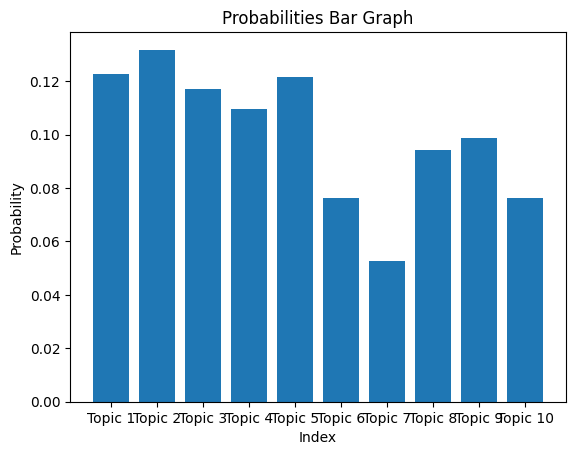

In [62]:
import matplotlib.pyplot as plt

# Create a list of indices for the x-axis
x = range(num_topics)
x_labels = ['Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5', 'Topic 6', 'Topic 7', 'Topic 8', 'Topic 9', 'Topic 10']

# Plotting the bar graph
plt.bar(x, normalized, tick_label=x_labels)

# Add labels and title
plt.xlabel('Index')
plt.ylabel('Probability')
plt.title('Probabilities Bar Graph')

# Display the plot
plt.show()